In [88]:
import pandas as pd
import numpy as np

In [89]:
import requests
from bs4 import BeautifulSoup
import re

target = 'https://3g.dxy.cn/newh5/view/pneumonia?scene=2&clicktime=1579582238&enterid=1579582238&from=timeline&isappinstalled=0'
req = requests.get(url=target)
req.encoding = 'urf-8'
html = req.text
soup = BeautifulSoup(html, 'html.parser')
cities = soup.find('div', {'class': 'getListByCountryTypeService1'})
# 每个省

cities = soup.find(id='getListByCountryTypeService1')
type(cities)
data_regexp = re.compile("\[(.*?)\]")
a=re.findall(data_regexp,str(cities))
a=a[0]
a=eval(a)
type(a)

data = {}
 
for province in a:
    try:

        name = province['provinceShortName']
        num = province['confirmedCount']
        if num == "":
            num = 0
        data['{}'.format(name)] = num
        print('疫情：', name, '确诊', num, '例')
    except AttributeError as e:
        continue
sorted_data={k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}

疫情： 湖北 确诊 730 例
疫情： 广东 确诊 78 例
疫情： 浙江 确诊 62 例
疫情： 北京 确诊 41 例
疫情： 上海 确诊 33 例
疫情： 湖南 确诊 43 例
疫情： 安徽 确诊 39 例
疫情： 重庆 确诊 57 例
疫情： 四川 确诊 28 例
疫情： 山东 确诊 27 例
疫情： 广西 确诊 23 例
疫情： 福建 确诊 18 例
疫情： 江苏 确诊 18 例
疫情： 河南 确诊 32 例
疫情： 海南 确诊 19 例
疫情： 天津 确诊 10 例
疫情： 江西 确诊 18 例
疫情： 陕西 确诊 15 例
疫情： 贵州 确诊 4 例
疫情： 辽宁 确诊 16 例
疫情： 香港 确诊 5 例
疫情： 黑龙江 确诊 9 例
疫情： 澳门 确诊 2 例
疫情： 新疆 确诊 3 例
疫情： 甘肃 确诊 4 例
疫情： 云南 确诊 11 例
疫情： 台湾 确诊 3 例
疫情： 山西 确诊 6 例
疫情： 吉林 确诊 4 例
疫情： 河北 确诊 8 例
疫情： 宁夏 确诊 3 例
疫情： 内蒙古 确诊 7 例
疫情： 青海 确诊 1 例


## Forecast the development of disease

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



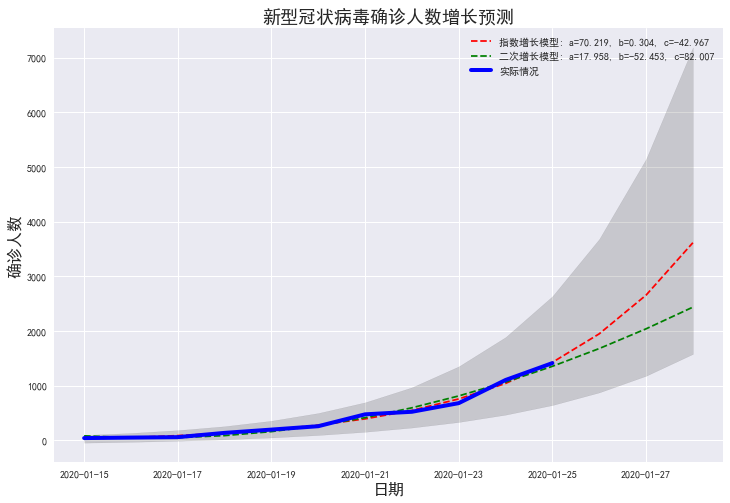

In [227]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = pd.read_excel('virus//virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.iloc[15:,:].reset_index(drop=True)

# Fitting model candidates
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
expsigma = np.sqrt(np.diagonal(exppcov))

def ployfunc(x, a, b, c):
    return a * x**2 + b * x + c
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)

# Create n days ahead forecast
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast']
forecast = pd.DataFrame(index=index,columns=columns)

forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])

# Plot
# -*- coding: utf-8 -*
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.figure(figsize=(12,8))
rapid_growth['expforecast']=expfunc(rapid_growth.index.values, *exppopt)
plt.plot(rapid_growth.Date, rapid_growth['expforecast'], 'r--',label='指数增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(exppopt))
# plotting the confidence intervals
bound_upper = expfunc(rapid_growth.index.values, *(exppopt + expsigma))
bound_lower = expfunc(rapid_growth.index.values, *(exppopt - expsigma))
plt.fill_between(rapid_growth.Date, bound_lower, bound_upper , color='black', alpha = 0.15)

rapid_growth['polyforecast']=ployfunc(rapid_growth.index.values, *polypopt)
plt.plot(rapid_growth.Date, rapid_growth['polyforecast'], 'g--',label='二次增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(polypopt))
plt.plot(rapid_growth.Date, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=4)
plt.legend()
plt.ylabel("确诊人数", fontsize=16)
plt.xlabel("日期", fontsize=16)
plt.title("新型冠状病毒确诊人数增长预测", fontsize=18)
plt.savefig("新型冠状病毒确诊人数增长预测.png")

In [223]:
rapid_growth['expforecast']=expfunc(rapid_growth.index.values, *exppopt)
rapid_growth

,Confirmed,Date,Suspected,expforecast,polyforecast
0,41.0,2020-01-15,NaN,27.251425,NaN
1,50.0,2020-01-16,NaN,52.201308,NaN
2,58.0,2020-01-17,NaN,86.016300,NaN
3,136.0,2020-01-18,NaN,131.846325,NaN
4,196.0,2020-01-19,40.0,193.960524,NaN
5,258.0,2020-01-20,127.0,278.144935,NaN
6,475.0,2020-01-21,260.0,392.241476,NaN
7,522.0,2020-01-22,330.0,546.878426,NaN
8,680.0,2020-01-23,450.0,756.460469,NaN
9,1103.0,2020-01-24,1056.0,1040.510517,NaN


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0.5, 0, '日期')

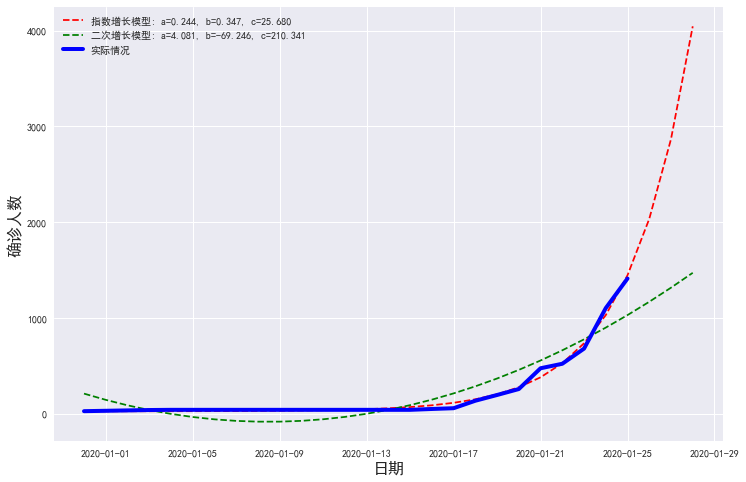

In [200]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
df = pd.read_excel('virus//virus.xlsx', sheet_name='Sheet1')
# Get the rapid growth part
rapid_growth=df.reset_index(drop=True)

# Fitting model candidates
def expfunc(x, a, b, c):
    return a * np.exp(b * x) + c
exppopt, exppcov = curve_fit(expfunc, rapid_growth.index.values, rapid_growth.Confirmed)
def ployfunc(x, a, b, c):
    return a * x**2 + b * x + c
polypopt, polypcov = curve_fit(ployfunc, rapid_growth.index.values, rapid_growth.Confirmed)

# Create n days ahead forecast
from datetime import timedelta 

n = 3
index = pd.date_range(rapid_growth.Date.iloc[-1]+timedelta(1), periods=n, freq='D')
columns=['expforecast','polyforecast']
forecast = pd.DataFrame(index=index,columns=columns)

forecast=forecast.reset_index().rename(columns={'index':'Date'})
forecast.index=forecast.index.values+len(rapid_growth.index.values)
rapid_growth=pd.concat([rapid_growth,forecast])

# Plot
# -*- coding: utf-8 -*
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.figure(figsize=(12,8))
plt.plot(rapid_growth.Date, expfunc(rapid_growth.index.values, *exppopt), 'r--',label='指数增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(exppopt))
plt.plot(rapid_growth.Date, ployfunc(rapid_growth.index.values, *polypopt), 'g--',label='二次增长模型: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(polypopt))
plt.plot(rapid_growth.Date, rapid_growth.Confirmed, 'b-', label='实际情况', linewidth=4)
plt.legend()
plt.ylabel("确诊人数", fontsize=16)
plt.xlabel("日期", fontsize=16)